<a href="https://colab.research.google.com/github/yj336/Yelp-sentiment-anaylsis/blob/master/%E2%80%9C_Yelp_04_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1YLqx8zMU6EXdHdIyYiY8Usdakc7o-0SE'}) # replace the id with id of file you want to access https://drive.google.com/open?id=1aehitOH9t2vkDlDxTY3qhZUuX3Mf7_6b
downloaded.GetContentFile('review_LV_5_years.csv')  

In [0]:
import pandas as pd

In [0]:
df_review = pd.read_csv('review_LV_5_years.csv')[['text','stars']]

In [0]:
df_review.head()

,text,stars
0,The food is always good and the prices are rea...,4.0
1,My wife ate here and I had pizza from another ...,5.0
2,Greenberg's Deli is part of the food court are...,4.0
3,I was a bit skeptical at first since it seems ...,4.0
4,Authentic New York Style Deli. This is in the...,5.0


In [0]:
comments = df_review.text.apply(lambda x: x.lower().split())

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import re
nltk.download("wordnet")
# Remove stop words
clean_comments = []
for comment in comments:
  clean_comment = []
  for word in comment:
    word = re.sub(r'[^a-zA-Z]', '', word)
    word = word.lower()
    if word not in stop:
      clean_comment.append(word)
  clean_comments.append(clean_comment)
# Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
wordnet = WordNetLemmatizer()

docs_lemma = list()
for doc in clean_comments:
    a = list()
    for word in doc:
        a.append(wordnet.lemmatize(word))
    docs_lemma.append(a)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
vocabulary = [word for doc in docs_lemma for word in doc]
vocabulary = sorted(list(set(vocabulary)))

In [0]:
from gensim.corpora import  WikiCorpus
from gensim.models import Word2Vec
import gensim.downloader as api

from sklearn.model_selection import train_test_split

In [0]:
#X = docs_lemma
y = df_review['stars'].apply(lambda x: 1 if x == 5 else 0)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_review.text, y, test_size = 0.2)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer_voca = TfidfVectorizer(vocabulary =vocabulary,stop_words=stopwords.words('english'))


X_train_tfidf_matrix = tfidf_vectorizer_voca.fit_transform(X_train)
X_test_tfidf_matrix =  tfidf_vectorizer_voca.transform(X_test)
#X_train_tfidf_matrix_voca = tfidf_vectorizer_voca.fit_transform(X_train)

In [0]:
import pickle
filename = 'tfidf.pkl'
with open(filename, 'wb') as file:
    pickle.dump(tfidf_vectorizer_voca, file)

In [0]:
from sklearn.naive_bayes import MultinomialNB
import time
start = time.time()
NB = MultinomialNB()
NB.fit(X_train_tfidf_matrix,y_train)
y_test_pred =NB.predict(X_test_tfidf_matrix)
end = time.time()
y_test_pred_prob = NB.predict_proba(X_test_tfidf_matrix)
print(end-start)

0.34178686141967773


In [0]:
filename = 'NB_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(NB, file)

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     82307
           1       0.81      0.79      0.80     75355

    accuracy                           0.81    157662
   macro avg       0.81      0.81      0.81    157662
weighted avg       0.81      0.81      0.81    157662



In [0]:
y_test

708162    0
40917     1
9487      1
734002    0
342047    1
         ..
262042    1
283981    0
587890    0
784297    1
412379    1
Name: stars, Length: 157662, dtype: int64

In [0]:
res = []
y_test_vec = y_test.reset_index() 

for i in range(len(y_test_vec)):
  if y_test_vec.iloc[i].stars != y_test_pred[i]:
    res.append(i)


In [0]:
res[0], res[100]

(4, 489)

In [0]:
y_test_vec.iloc[489]

index    252272
stars         1
Name: 489, dtype: int64

In [0]:
df_review.iloc[252272].text

"So my boyfriend & I are in Vegas and he suggests... Tournament of Kings. Um.... we're in VEGAS. Parties! Gambling! Booze!! and you want to go to... this? So we popped by Tix4Tonight and picked up some discounted tickets. \r\n\r\nI was blown away and so very happy with the purchase.\r\n\r\nFirst of all, the theatre is small so no matter where you sit you get a great view!!\r\n\r\nSecondly, I didn't realize it was a dinner theatre type event. However, what I love about this, you get to eat while watching the show before you. As oppose to eat. Part 1 starts. Main course comes out during intermission... and so on so forth. \r\n\r\nThirdly, you get to eat without using utensils and it's awesome. I thought I would be a little grossed out at this part but I quite enjoyed it.\r\n\r\nFourth, the food is pretty good! You get your own little chicken (not slices of meat) with potatoes \\veggies\\ (which is actually just a broccoli stem), tomato soup, coffee/tea/soda/water, a biscuit and an apple 

In [0]:
len(y_test_vec)

157662

In [0]:
from sklearn.metrics import roc_curve

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred_prob[:,1])

#from sklearn.metrics import auc
#auc_keras = auc(fpr_keras, tpr_keras)

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)


0.8096053582981314

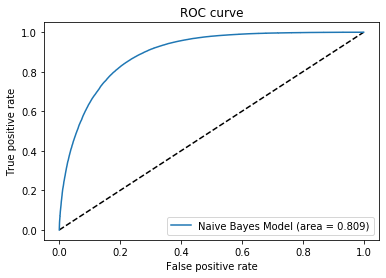

In [0]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Naive Bayes Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_tfidf_matrix,y_train)
y_test_pred =svc.predict(X_test_tfidf_matrix)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

In [0]:
from sklearn.ensemble import RandomForestClassifier
rdc = RandomForestClassifier()
rdc.fit(X_train_tfidf_matrix,y_train)
y_test_pred =rdc.predict(X_test_tfidf_matrix)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78     82128
           1       0.79      0.69      0.73     75534

    accuracy                           0.76    157662
   macro avg       0.77      0.76      0.76    157662
weighted avg       0.77      0.76      0.76    157662

